Importance Sampling Example: Computing Normalizing Constant of Unnormalized PDF
Target: exp(-x²/4) * (1 + sin²(2x))

Computing normalizing constant using 10,000 samples:

Proposal: Normal(0,2)
  Normalizing constant: 5.335397
  Effective Sample Size: 8216.9 (82.2%)
  CV of weights: 0.466
  Efficiency: Good

Proposal: Normal(0,3)
  Normalizing constant: 5.315148
  Effective Sample Size: 5969.2 (59.7%)
  CV of weights: 0.822
  Efficiency: Good

Proposal: Mixture
  Normalizing constant: 5.359197
  Effective Sample Size: 9118.0 (91.2%)
  CV of weights: 0.311
  Efficiency: Good

Creating visualization for best proposal: Mixture


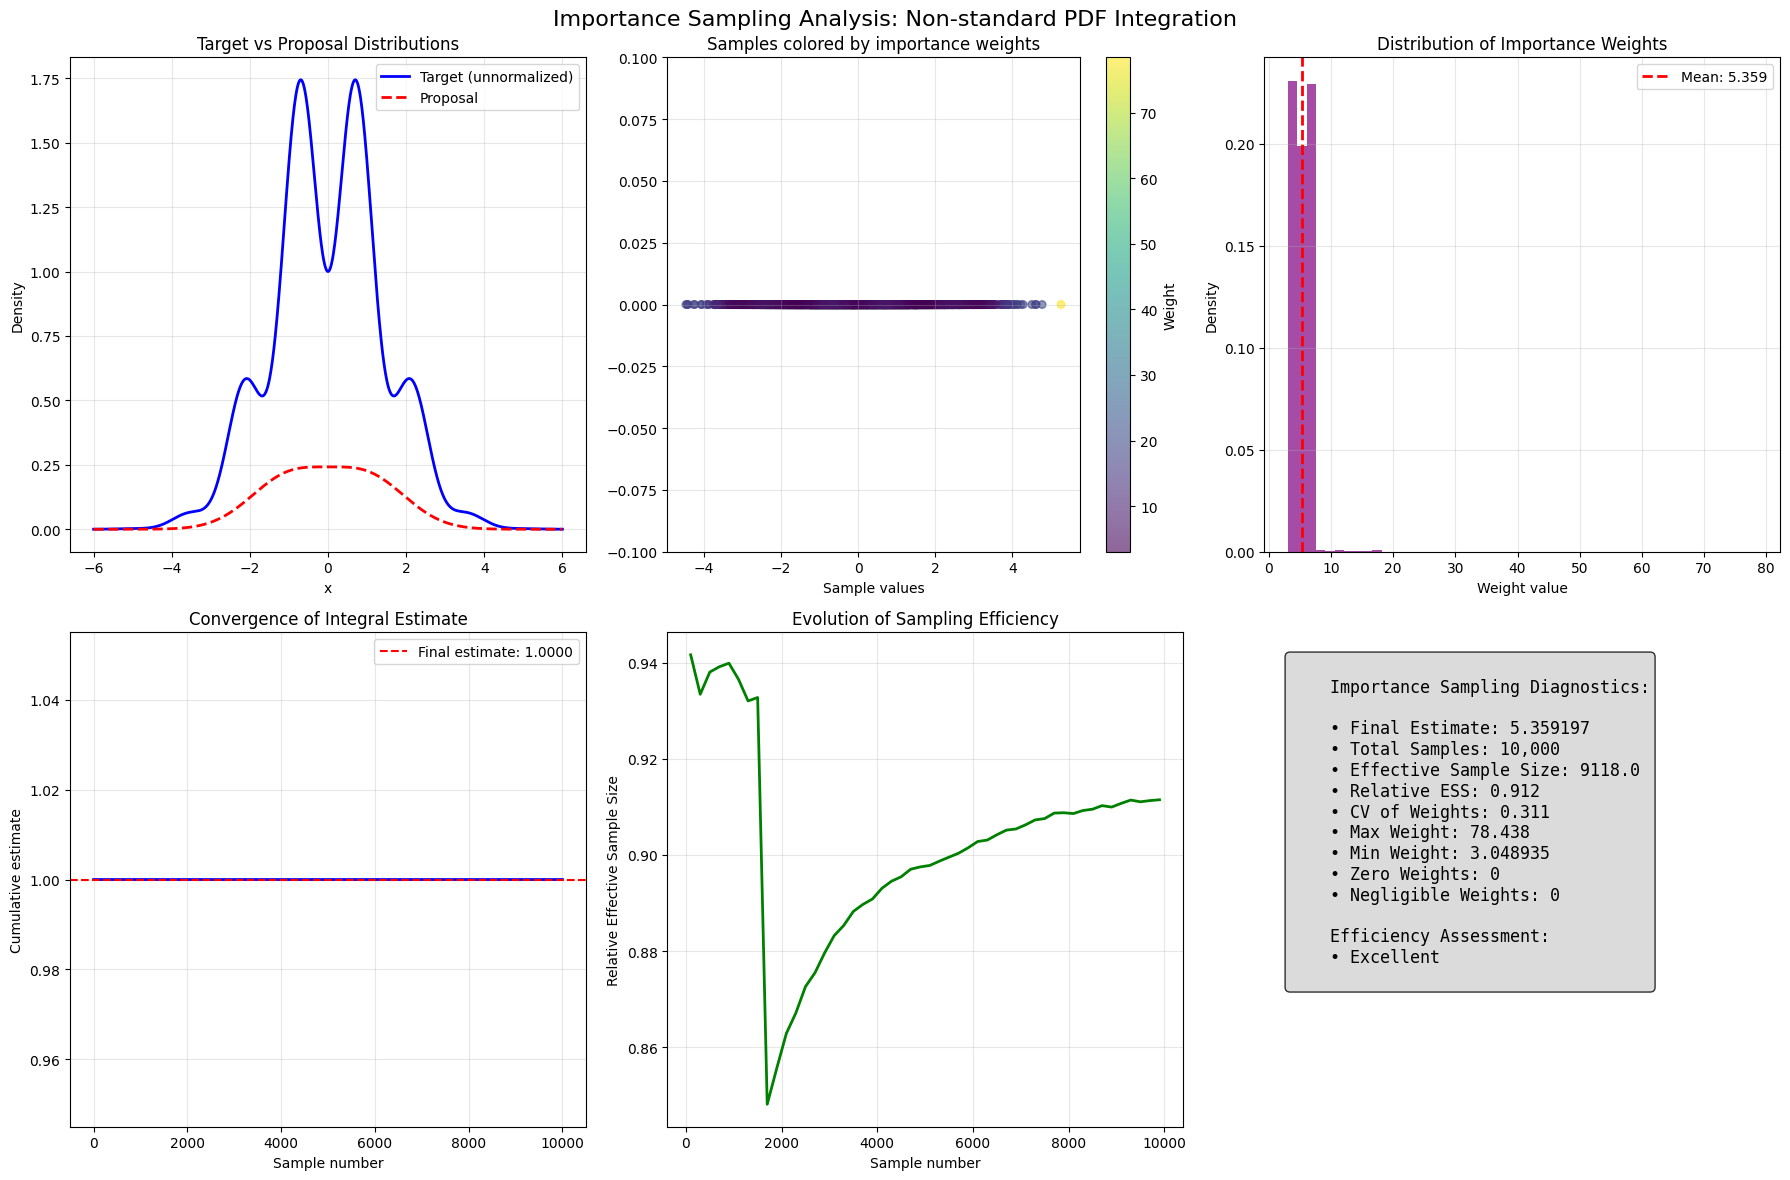


Numerical Integration Reference (scipy.integrate):
Numerical integration result: 5.317361

Comparison with Importance Sampling:
  Normal(0,2): Error = 0.018035 (0.34%)
  Normal(0,3): Error = 0.002214 (0.04%)
  Mixture: Error = 0.041836 (0.79%)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from mc_lab.importance_sampling import (
    ImportanceSampler,
    MixtureNormal,
    NonStandardDistribution,
    Normal,
    create_visualization,
)

# Example: Computing the integral of our non-standard unnormalized PDF


print("Importance Sampling Example: Computing Normalizing Constant of Unnormalized PDF")
print("Target: exp(-x²/4) * (1 + sin²(2x))")
print("=" * 70)

# Define our complex target distribution: exp(-x²/4) * (1 + sin²(2x))
target_dist = NonStandardDistribution()


# We want to compute the normalizing constant Z = ∫ p̃(x) dx
# Using regular importance sampling: Z ≈ (1/N) * Σ[p̃(x_i)/q(x_i)] = mean(weights)
# So our function f(x) = 1 and we use the regular IS estimator
def integration_function(x):
    return np.ones_like(x)


# Try different proposal distributions
proposals = {
    "Normal(0,2)": Normal(mean=0, std=2),
    "Normal(0,3)": Normal(mean=0, std=3),
    "Mixture": MixtureNormal(-1, 1, 1, 1, 0.5),
}

results = {}
n_samples = 10000

print(f"\nComputing normalizing constant using {n_samples:,} samples:\n")

for name, proposal in proposals.items():
    # Create importance sampler (use_self_normalized=False for computing normalizing constants)
    sampler = ImportanceSampler(
        target_dist=target_dist,
        proposal_dist=proposal,
        function=integration_function,
        use_self_normalized=False,  # Use regular IS to compute normalizing constant
    )

    # Perform sampling
    result = sampler.estimate(
        n_samples=n_samples, return_diagnostics=True, return_samples=True
    )

    results[name] = result

    # Print results
    diag = result["diagnostics"]
    print(f"Proposal: {name}")
    print(f"  Normalizing constant: {result['estimate']:.6f}")
    print(
        f"  Effective Sample Size: {diag['effective_sample_size']:.1f} ({diag['relative_ess']:.1%})"
    )
    print(f"  CV of weights: {diag['cv_weights']:.3f}")
    print(f"  Efficiency: {'Good' if diag['relative_ess'] > 0.1 else 'Poor'}")
    print()

# Create visualization for the best performing proposal
best_proposal = max(
    results.keys(), key=lambda k: results[k]["diagnostics"]["relative_ess"]
)

print(f"Creating visualization for best proposal: {best_proposal}")

fig = create_visualization(
    target_dist=target_dist,
    proposal_dist=proposals[best_proposal],
    sampler_results=results[best_proposal],
)

plt.show()

# Monte Carlo reference (if we could sample directly)
print("\nNumerical Integration Reference (scipy.integrate):")
try:
    from scipy import integrate

    true_integral, _ = integrate.quad(lambda x: target_dist.pdf(x), -10, 10, limit=100)
    print(f"Numerical integration result: {true_integral:.6f}")

    print("\nComparison with Importance Sampling:")
    for name, result in results.items():
        error = abs(result["estimate"] - true_integral)
        rel_error = error / true_integral * 100
        print(f"  {name}: Error = {error:.6f} ({rel_error:.2f}%)")

except ImportError:
    print("scipy not available for numerical integration reference")